In [1]:
%matplotlib inline

Reinforcement Learning (Actor-Critic) Tutorial
=====================================
**Author**: `Zhenyu Yan <https://github.com/michael1015198808>`

**Based On**: [REINFORCEMENT LEARNING (DQN) TUTORIAL](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from tqdm import trange
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import IPython

env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [3]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

In [4]:
GAMMA = 0.99

# Get number of actions from gym action space
n_actions = env.action_space.n

actor  = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 8), nn.ReLU(), nn.Linear(8, 2))
optimizer = optim.SGD(actor.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=list(range(500, 5001, 500)), gamma=0.6)

steps_done = 0

episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 1000:
        means = durations_t.unfold(0, 1000, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(999), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        # display.clear_output()
        display.display(plt.gcf())

 50%|███████████████████████████████████████▎                                       | 996/2000 [00:17<00:21, 46.33it/s]

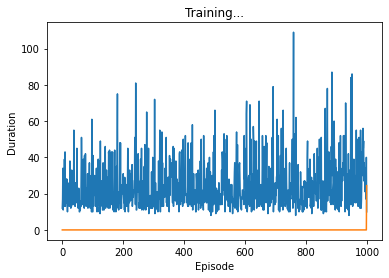

<Figure size 432x288 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████████▉| 1997/2000 [00:48<00:00, 19.10it/s]

<Figure size 432x288 with 0 Axes>

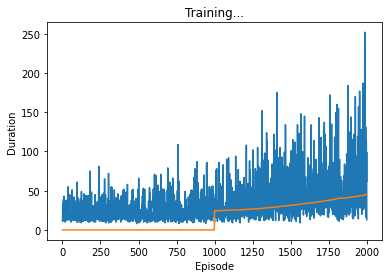

<Figure size 432x288 with 0 Axes>

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.75it/s]


<Figure size 432x288 with 0 Axes>

In [5]:
num_episodes = 50000
# It'll take about 2 hours to finish 50000 episodes. You may decrease this number to meet your need.
loss = 0.0
pbar = trange(num_episodes)
for i_episode in pbar:
    # Initialize the environment and state
    state = torch.tensor([env.reset()], dtype=torch.float32)
    states = []
    actions = []
    for t in count():
        # Select and perform an action
        prob = torch.softmax(actor(state), dim=-1)
        action = np.random.choice(range(prob.shape[1]), p=prob.detach().numpy()[0])

        states.append(state)
        actions.append(action)

        obs, _, done, _ = env.step(action)

        if not done:
            next_state = torch.tensor([obs], dtype=torch.float32)
        else:
            next_state = None

        # Move to the next state
        state = next_state

        if done:
            episode_durations.append(t + 1)
            break

    loss = 0.0
    reward = 0
    for state, action in zip(reversed(states), reversed(actions)):
        prob_grad = torch.log_softmax(actor(state), dim=-1)
        reward = reward * GAMMA + 1
        loss -= reward * prob_grad[0][action]

    loss /= t
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if i_episode % 1000 == 999:
        plot_durations()